# Quadratic-Regularized Optimal Transport (instead of Shannon entropy)

In this notebook, we consider an alternative regularization of the optimal transport (OT) problem, based on a **quadratic penalty** instead of Shannon entropy.  
We introduce the Primal-Dual Hybrid Gradient method that solves OT with qudaratic regularization.

---

## Problem statement

We define the **quadratic-regularized OT problem**:

$$
\begin{aligned}
\min_{P \in \mathbb{R}^{n \times m}} \quad
& \sum_{i=1}^{n} \sum_{j=1}^{m} C_{ij} P_{ij}
+ \frac{\varepsilon}{2} \sum_{i=1}^{n} \sum_{j=1}^{m} P_{ij}^2 \\
\text{s.t. } \quad
& P \mathbf{1}_m = \rho_1, \\
& P^\top \mathbf{1}_n = \rho_2, \\
& P \ge 0,
\end{aligned}
$$

for a given cost matrix $C \in \mathbb{R}^{n \times m}$, marginals $\rho_1 \in \mathbb{R}^n_{++}$, $\rho_2 \in \mathbb{R}^m_{++}$ and regularization strength $\varepsilon > 0$.


Adding quadratic regularization brings a few nice properties we do not have in unregularized OT:

1. **Strict convexity** of the objective, which guarantees **uniqueness** of the solution $P^*$.
2. **Smoothness** of the regularization term, which enables efficient first-order and primal–dual algorithms.
3. A natural connection to **penalized linear programs**.

Unlike entropy regularization, quadratic regularization **does not** yield a multiplicative scaling structure (no kernel matrix $K = e^{-C/\varepsilon}$), and positivity must be enforced explicitly via the projection of $P$ onto $\mathbb{R}_{++}$.

---

## Lagrangian and optimality conditions

Introduce dual variables $w_1 \in \mathbb{R}^n$ and $w_2 \in \mathbb{R}^m$ for the marginal constraints. Then we derive the dual problem in the same way we did for the Shannon entropy:

The Lagrangian is

$$
\mathcal{L}(P, w_1, w_2)
=
\sum_{i,j} C_{ij} P_{ij}
+ \frac{\varepsilon}{2} \sum_{i,j} P_{ij}^2
+ \sum_{i,j} w_{1,i} (\rho_{1,i} - P_{ij})
+ \sum_{i,j} w_{2,i} (\rho_2 - P_{ij}),
$$

where $\langle C, P \rangle = \sum_{i,j} C_{ij} P_{ij}$ and  $\|P\|_F^2 = \sum_{i,j} P_{ij}^2$.

Taking the derivative with respect to $P_{ij}$ gives the stationarity condition:

$$
0 = C_{ij} + \varepsilon P_{ij} - w_{1,i} - w_{2,j}.
$$

Solving for $P_{ij}$ (ignoring the positivity constraint for the moment):

$$
P_{ij} = \frac{w_{1,i} + w_{2,j} - C_{ij}}{\varepsilon}.
$$

Because we must enforce $P \ge 0$, the optimal plan satisfies the projected form

$$
P^* =
\left[
\frac{1}{\varepsilon}
\left(
w_1 \mathbf{1}_m^\top
+ \mathbf{1}_n w_2^\top
- C
\right)
\right]_+,
$$

where $[\,\cdot\,]_+$ denotes elementwise projection onto $\mathbb{R}_+$:

$$
[x]_+ = \max(x, 0).
$$

---

## Dual problem

Plugging the optimal $P(w_1,w_2)$ back into the Lagrangian yields an unconstrained dual problem:

$$
\max_{w_1 \in \mathbb{R}^n,\; w_2 \in \mathbb{R}^m}
\quad
\rho_1 \cdot w_1 + \rho_2 \cdot w_2
- \frac{1}{2\varepsilon} \sum_{i=1}^n \sum_{j=1}^m \left(\left[w_{1,i} + w_{1,j} - C_{ij}\right]_+\right)^2.
$$

This mirrors the entropy-regularized dual, but replaces the exponential soft-penalty with a quadratic one and introduces an explicit projection.


## Comparison to Shannon entropy

In the entropy-regularized setting, the optimal plan has the form

$$
P = \operatorname{diag}(u)\, K \,\operatorname{diag}(v),
\qquad
K = e^{-C/\varepsilon},
$$

and positivity of the coupling $P$ is obtained automatically from the exponential structure.  
In contrast, for quadratic regularization

- there is **no kernel matrix** $K$,
- there is **no multiplicative scaling** representation.

To see why this matters, recall the logic behind the Sinkhorn algorithm.  
At each iteration, we update $(u^k, v^k)$ by enforcing the marginal constraints
$$
\sum_{j} P_{ij} = \rho_{1,i}
\quad\text{and}\quad
\sum_{i} P_{ij} = \rho_{2,j}.
$$

Because in the entropy case we have
$$
P_{ij} = \exp\!\left(\frac{w_{1,i} + w_{2,j} - C_{ij}}{\varepsilon}\right)
= u_i\, K_{ij}\, v_j,
$$
the row-sum constraint becomes a *simple scaling equation*:
$$
\sum_{j} P_{ij} = \sum_{j} u_i K_{ij} v_j
= u_i (K v)_i
= \rho_{1,i}.
$$
Equivalently, in vector form,
$$
\operatorname{diag}(u)\, K\, v = \rho_1,
$$
which immediately gives the explicit Sinkhorn update
$$
u^{k+1} = \frac{\rho_1}{K v^{k}}.
$$
(Here and below, divisions are elementwise.)

## Why Sinkhorn algorithm is "impossible" for the quadratic regularization?

If we plug in the quadratic-regularized expression for the optimal coupling,
$$
P_{ij} = \left[\frac{1}{\varepsilon}\left(w_{1,i} + w_{2,j} - C_{ij}\right)\right]_+,
$$
then enforcing the first marginal constraint leads to
$$
\sum_{j=1}^m \left[\frac{1}{\varepsilon}\left(w_{1,i} + w_{2,j} - C_{ij}\right)\right]_+
= \rho_{1,i}.
$$

The key difference is that this equation does **not** admit an explicit, multiplicative “rescaling” update like in Sinkhorn.  
The reason is that the expression inside the sum involves a **projection** $[\,\cdot\,]_+$, so the dependence on $w_{1,i}$ is **piecewise** and coupled with the unknown active set
$$
\{\, j : w_{1,i} + w_{2,j} - C_{ij} > 0 \,\}.
$$
As a result, the constraint is no longer of the form
$$
u_i (K v)_i = \rho_{1,i},
$$
and there is no decoupled representation $P = \operatorname{diag}(u)\, K\, \operatorname{diag}(v)$ to exploit.

In other words, the simple Sinkhorn updates exist **only because** the entropy-regularized solution is an **exponential**, which factorizes into $u_i K_{ij} v_j$.  
Once the coupling is no longer exponential (as in the quadratic case), the multiplicative scaling structure disappears, and with it the classical Sinkhorn iteration
 
---



## Summary: entropy vs quadratic regularization

| Property | Entropy-regularized OT | Quadratic-regularized OT |
|---|---|---|
| Regularizer | $\sum P_{ij} \log P_{ij}$ | $\frac{1}{2} \sum P_{ij}^2$ |
| Strict convexity | yes | yes |
| Solution structure | $P = \mathrm{diag}(u)K\mathrm{diag}(v)$ | $P = [(\,w_1 + w_2 - C\,)/\varepsilon]_+$ |
| Positivity | implicit | explicit (projection) |
| Typical algorithm | Sinkhorn | PDHG / projected dual ascent |
| Sparsity | dense | sparse |

## Takeaway

Quadratic regularization produces a **unique** and **smoothly regularized** OT solution, but it does **not** admit Sinkhorn’s multiplicative scaling structure.  
Instead, the transport plan is recovered from **dual potentials** via an affine expression followed by **projection onto the nonnegative orthant**.

In [1]:
import numpy as np  # Our main tool
import ot  # POT library
import matplotlib.pyplot as plt  # For visualization
from ot import plot  # POT tools for visualization
from ot.datasets import make_1D_gauss  # Convenient tool to initialize marginals as Gauss distribution

## Dual optimization

The following approach minimizes smooth unconstrained objective function
$$
D(w_1, w_2) = - \rho_1 \cdot w_1 - \rho_2 \cdot w_2
+ \frac{1}{2\varepsilon} \sum_{i=1}^n \sum_{j=1}^m \left(\left[w_{1,i} + w_{1,j} - C_{ij}\right]_+\right)^2
$$
using optimization library. In this example we use `scipy.optimize` with L-BFGS method.

In [2]:
from scipy.optimize import minimize

def solve_quadratic_ot_dual_grad_ascent(C, rho1, rho2, eps, maxiter=2000, tol=1e-9):
    n, m = C.shape

    x0 = np.zeros((n + m,))

    def unpack(x):
        w1 = x[:n]
        w2 = x[n:]
        return w1, w2

    def dual_and_grad(x):
        w1, w2 = unpack(x)

        # s_ij = w1_i + w2_j - C_ij
        s = w1[:, None] + w2[None, :] - C
        s_proj = np.maximum(s, 0.0)

        # Dual objective:
        # f = rho1·w1 + rho2·w2 - (1/(2 eps)) * ||Sp||_F^2
        f = rho1 @ w1 + rho2 @ w2 - (0.5 / eps) * np.sum(s_proj * s_proj)
        
        # Gradient:
        # df/dw1_i = rho1_i - (1/eps) * sum_j Sp_ij
        # df/dw2_j = rho2_j - (1/eps) * sum_i Sp_ij
        row_sum = s_proj.sum(axis=1)  # length n
        col_sum = s_proj.sum(axis=0)  # length m

        grad_w1 = rho1 - (1.0 / eps) * row_sum
        grad_w2 = rho2 - (1.0 / eps) * col_sum

        # Pack gradient for x (exclude w1[0] since fixed):
        grad_x = np.concatenate([grad_w1, grad_w2])
        return f, grad_x

    # SciPy minimizes, so we minimize -f (equivalently, maximize f)
    def fun(x):
        f, _ = dual_and_grad(x)
        return -f

    def jac(x):
        _, g = dual_and_grad(x)
        return -g

    res = minimize(
        fun,
        x0,
        jac=jac,
        method="L-BFGS-B",
        options={"maxiter": maxiter, "ftol": tol, "gtol": tol}
    )

    w1_opt, w2_opt = unpack(res.x)
    s = w1_opt[:, None] + w2_opt[None, :] - C
    P = np.maximum(s, 0.0) / eps

    # Diagnostics
    r1 = P.sum(axis=1) - rho1
    r2 = P.sum(axis=0) - rho2

    # Dual objective at optimum (maximize)
    f_opt, _ = dual_and_grad(res.x)

    info = {
        "success": res.success,
        "status": res.status,
        "message": res.message,
        "niter": int(res.nit) if hasattr(res, "nit") else None,
        "dual_obj": float(f_opt),
        "max_row_marg_err": float(np.max(np.abs(r1))),
        "max_col_marg_err": float(np.max(np.abs(r2))),
        "row_marg_err_l2": float(np.linalg.norm(r1)),
        "col_marg_err_l2": float(np.linalg.norm(r2)),
    }

    return w1_opt, w2_opt, P, info

In [3]:
n = 200

# Initialize marginals as normal distribution restricted to [0, n], normalized to 1
rho1 = make_1D_gauss(n, m=50, s=20)  # m=mean, s=std
rho2 = make_1D_gauss(n, m=100, s=50)

# Initialize cost matrix
x = np.arange(n, dtype=np.float64)
C = ot.dist(x.reshape((n, 1)), x.reshape((n, 1)))  # OT tool for building distance matrix
C = C / C.max()  # Normalize for Sinkhorn algorithm stability

In [38]:
w1, w2, P, info = solve_quadratic_ot_dual_grad_ascent(C, rho1, rho2, 0.01, maxiter=10000, tol=1e-15)
print("Solver info:", info)
print("Primal plan stats:")
print("  P min/max:", P.min(), P.max())
print("  row sum error (max abs):", info["max_row_marg_err"])
print("  col sum error (max abs):", info["max_col_marg_err"])

Solver info: {'success': False, 'status': 1, 'message': 'STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT', 'niter': 10000, 'dual_obj': 0.07720933185030834, 'max_row_marg_err': 1.1647753897518064e-05, 'max_col_marg_err': 3.903563340404794e-05, 'row_marg_err_l2': 3.897364033607276e-05, 'col_marg_err_l2': 5.845770661048226e-05}
Primal plan stats:
  P min/max: 0.0 0.006713050164196266
  row sum error (max abs): 1.1647753897518064e-05
  col sum error (max abs): 3.903563340404794e-05


(<Axes: >, <Axes: >, <Axes: >)

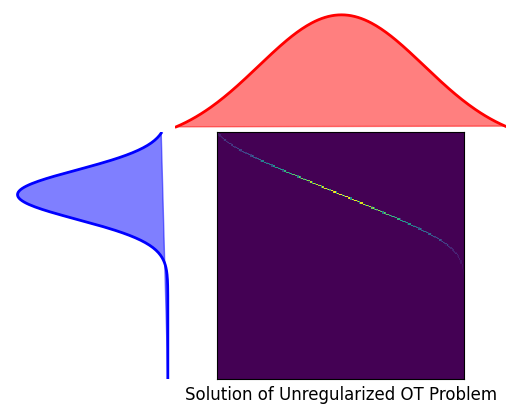

In [39]:
P_star = ot.emd(rho1, rho2, C)
plot.plot1D_mat(rho1, rho2, P_star, 'Solution of Unregularized OT Problem', coupling_cmap='viridis')

(<Axes: >, <Axes: >, <Axes: >)

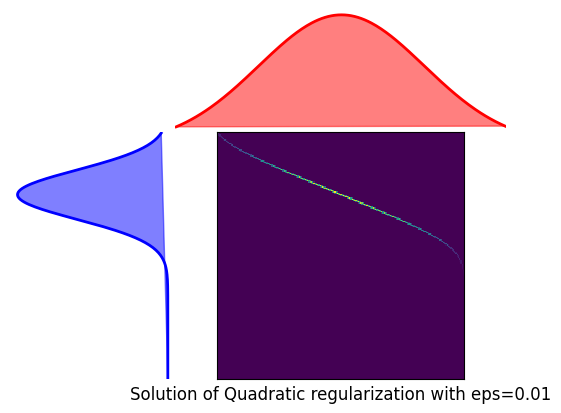

In [40]:
P_star = ot.emd(rho1, rho2, C)
plot.plot1D_mat(rho1, rho2, P, "Solution of Quadratic regularization with eps=0.01", coupling_cmap='viridis')

In [41]:
objective_star = np.sum(C*P_star)
objective_quadratic = np.sum(C*P)
print("Difference with true OT objective:", float(np.abs(objective_quadratic - objective_star)))

Difference with true OT objective: 2.2270543660524167e-05


## PDHG algorithm

### Proximal Operator

Given a proper, convex, lower-semicontinuous function $f : \mathbb{R}^d \to \mathbb{R}\cup\{+\infty\}$, its **proximal operator** with step size \(\tau > 0\) is defined as
$$
\operatorname{prox}_{\tau f}(x)
=
\arg\min_{y \in \mathbb{R}^d}
\left\{
\frac{1}{2}\|y - x\|_2^2 + \tau f(y)
\right\}.
$$

Intuitively:
- the proximal operator balances staying close to $x$,
- while reducing the value of $f$.


If $f$ is convex, we can define prox as
$$
\operatorname{prox}_{\tau f} = (I + \tau\, \partial f)^{-1}.
$$


PDHG algorithm solves the following convex-concave saddle-point problems
$$
  \min_x \min_y f(x) + \langle Kx, y \rangle - g^*(y),
$$
where $f$ and $g$ are convex functions and $K$ is some linear operator.
$$
  g^*(y) = \min_{s} \langle s, y\rangle  - g(s) \quad \text{-} \quad \text{is convex conjugate}.
$$

Given $\tau, \sigma \leq \lVert K \rVert^2$, the PDHG updates are the following

$$
\begin{cases}
y^{k+1}=\operatorname{prox}_{\sigma g^*}\!\left(y^k+\sigma K\bar x^k\right),\\[4pt]
x^{k+1}=\operatorname{prox}_{\tau f}\!\left(x^k-\tau K^\top y^{k+1}\right),\\[4pt]
\bar x^{k+1}=x^{k+1}+\theta\left(x^{k+1}-x^k\right),
\end{cases}
$$

---

Now we formulate OT problem as the saddle point problem. In this case $x=P$, $y=(u,v)$, and $K(P)=(P\mathbf 1,\ P^\top\mathbf 1)$:

$$
\min_{P}\max_{u,v}\;
\underbrace{\langle C,P\rangle + \frac{\varepsilon}{2}\|P\|_F^2 + \iota_{\{P\ge 0\}}(P)}_{f(P)}
+
\left\langle 
\begin{pmatrix}P\mathbf 1\\ P^\top\mathbf 1\end{pmatrix},
\begin{pmatrix}u\\v\end{pmatrix}
\right\rangle
-
\underbrace{(\mu\cdot u + \nu\cdot v)}_{g^*(u,v)}.
$$

Expanding the coupling term gives
$$
\langle K(P), (u,v)\rangle
=
u^\top(P\mathbf 1)+v^\top(P^\top\mathbf 1)
=
\langle u\mathbf 1^\top + \mathbf 1 v^\top,\; P\rangle.
$$

So the saddle-point objective can also be written as
$$
\min_{P\ge 0}\max_{u,v}\;
\langle C,P\rangle + \frac{\varepsilon}{2}\|P\|_F^2
+
u^\top(P\mathbf 1-\mu)
+
v^\top(P^\top\mathbf 1-\nu).
$$

---

###  Primal update as a proximal step

The primal PDHG update can be written as
$$
P^{k+1}
=
\operatorname{prox}_{ \tau(\langle C, \cdot \rangle +\frac{\varepsilon}{2}\|\cdot\|_F^2 + \iota_{\{\cdot \ge 0\}})}
\big(
P^k + \tau(u^k \mathbf 1^\top +\mathbf 1 (v^k)^\top)
\big).
$$

Because the proximal operator is separable over entries, this yields the closed form
$$
P^{k+1}
=
\left[
\frac{P^k - \tau(C - u^k \mathbf 1^\top - \mathbf 1 (v^k)^\top)}
{1 + \tau \varepsilon}
\right]_+,
$$
which matches the implementation.

---

###  Dual update as a proximal step

The dual variables \(u\) and \(v\) are updated via
$$
\begin{aligned}
u^{k+1}
&= \operatorname{prox}_{\sigma g^*}
\big(u^k + \sigma(2r^{k+1} - r^k)\big), \\
v^{k+1}
&= \operatorname{prox}_{\sigma g^*}
\big(v^k + \sigma(2c^{k+1} - c^k)\big),
\end{aligned}
$$
where
$$
r^{k+1} = P^{k+1}\mathbf 1,
\qquad
c^{k+1} = (P^{k+1})^\top \mathbf 1.
$$

Since $g^*$ is identically zero (there are no explicit constraints on \(u,v\)), its proximal operator is the identity:
$$
\operatorname{prox}_{\sigma g^*}(x) = x.
$$

Thus, the dual updates reduce to simple gradient ascent steps with extrapolation:
$$
\begin{aligned}
u^{k+1}
&= u^k + \sigma(\mu - (2r^{k+1} - r^k)), \\
v^{k+1}
&= v^k + \sigma(\nu - (2c^{k+1} - c^k)).
\end{aligned}
$$


In [42]:
import numpy as np
from dataclasses import dataclass

@dataclass
class PDHGInfo:
    n_iter: int
    obj: float
    row_err_l2: float
    col_err_l2: float

def pdhg_quadratic_ot(
    C: np.ndarray,
    mu: np.ndarray,
    nu: np.ndarray,
    eps: float = 1e-2,
    tau: float = 0.2,
    sigma: float = 0.2,
    max_iter: int = 2000,
    tol: float = 1e-8,
    check_every: int = 64,
    dtype=np.float64,
):
    """
    Simple, fast NumPy PDHG for quadratic-regularized OT:

        min_{P >= 0} <C, P> + (eps/2)||P||_F^2
        s.t. P 1 = mu,  P^T 1 = nu

    PDHG-style updates:
      grad = C - (u[:,None] + v[None,:])
      P^{k+1} = Proj_{>=0}((P^k - tau*grad)/(1 + tau*eps))
      u^{k+1} = u^k + sigma*(mu - (2*row_{k+1} - row_k))
      v^{k+1} = v^k + sigma*(nu - (2*col_{k+1} - col_k))

    Returns
    -------
    P : (n,m) ndarray
    u : (n,) ndarray
    v : (m,) ndarray
    info : PDHGInfo
    """
    C = np.asarray(C, dtype=dtype)
    mu = np.asarray(mu, dtype=dtype)
    nu = np.asarray(nu, dtype=dtype)

    n, m = C.shape
    if mu.shape != (n,) or nu.shape != (m,):
        raise ValueError(f"Expected mu shape ({n},), nu shape ({m},). Got {mu.shape}, {nu.shape}.")
    if eps < 0:
        raise ValueError("eps must be >= 0.")

    # --- init ---
    P = np.outer(mu, nu) / mu.sum()
    
    # Duals
    u = np.zeros(n, dtype=dtype)
    v = np.zeros(m, dtype=dtype)

    row_prev = P.sum(axis=1)
    col_prev = P.sum(axis=0)

    inv_denom = 1.0 / (1.0 + tau * eps)

    for k in range(max_iter):  
        # ---- primal step ----
        # grad = C - (u + v) in broadcast form
        grad = C - (u[:, None] + v[None, :])
        
        P = (P - tau * grad) * inv_denom
        # projection to nonnegative
        np.maximum(P, 0.0, out=P)

        # ---- marginals ----
        row = P.sum(axis=1)
        col = P.sum(axis=0)

        # ---- dual step (with extrapolation) ----
        u += sigma * (mu - (2.0 * row - row_prev))
        v += sigma * (nu - (2.0 * col - col_prev))

        row_prev = row
        col_prev = col

        # ---- stopping check (not every iter to save time) ----
        if (k % check_every) == 0:
            err = max(np.linalg.norm(row - mu), np.linalg.norm(col - nu))
            if err <= tol:
                break

    # final diagnostics
    row = P.sum(axis=1)
    col = P.sum(axis=0)
    row_err = row - mu
    col_err = col - nu
    obj = float(np.sum(C * P) + 0.5 * eps * np.sum(P * P))

    info = PDHGInfo(
        n_iter=k,
        obj=obj,
        row_err_l2=np.linalg.norm(row_err),
        col_err_l2=np.linalg.norm(col_err),
    )

    return P, u, v, info


In [43]:
P, u, v, info = pdhg_quadratic_ot(C, rho1, rho2, eps=0.01, tau=0.18, sigma=0.18, max_iter=10000, tol=1e-10)
info.col_err_l2, info.row_err_l2

(np.float64(1.1235423019342335e-07), np.float64(2.039799955470831e-07))

(<Axes: >, <Axes: >, <Axes: >)

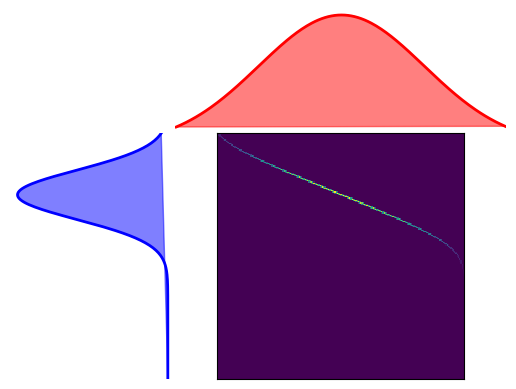

In [44]:
plot.plot1D_mat(rho1, rho2, P, coupling_cmap='viridis')

In [45]:
objective_star = np.sum(C*P_star)
objective_quadratic = np.sum(C*P)
print("Difference with true OT objective:", float(np.abs(objective_quadratic - objective_star)))

Difference with true OT objective: 4.195696696074336e-06


## Imporved PDHG (raPDHG or PDLP) algorithm

- **Adaptive step sizes**: PDLP dynamically adjusts the primal and dual step sizes during the iterations based on observed progress, removing the need for hand-tuning step size at the beginning.

- **Primal–dual weight balancing**: The algorithm adaptively rescales primal and dual variables to balance their relative progress, preventing oscillations that slow convergence speed.

- **Restart and averaging strategies**: Periodic restarts with weighted averaging of iterates stabilizes convergence and improves solution quality.

- **Improved robustness on large-scale problems**: These enhancements make PDLP far more reliable than vanilla PDHG on OT instances.

In [12]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

In [13]:
from algorithms.rapdhg import raPDHG, create_ot_problem
import jax
jax.config.update("jax_enable_x64", True)

In [47]:
def solve_quadratic_ot_rapdhg(rho1, rho2, C, eps, tol, maxiter):
  optimizer = raPDHG(
    verbose=False,
    eps_abs=tol,
    eps_rel=tol,
    iteration_limit=maxiter,
    reg=eps
  )

  problem = create_ot_problem(C, rho1, rho2)

  state, _ = optimizer.optimize(problem, dim=rho1.shape[0])
  return state
  

state = solve_quadratic_ot_rapdhg(rho1, rho2, C, eps=0.001, tol=1e-6, maxiter=10000)
P = state.avg_primal_solution

In [48]:
np.linalg.norm(np.sum(P, axis=1) - rho1), np.linalg.norm(np.sum(P, axis=0) - rho2)

(np.float64(3.041091027090293e-06), np.float64(4.0482327878433274e-07))

(<Axes: >, <Axes: >, <Axes: >)

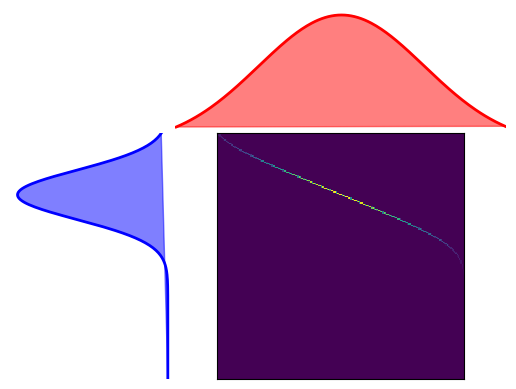

In [49]:
plot.plot1D_mat(rho1, rho2, P, coupling_cmap='viridis')

In [50]:
objective_star = np.sum(C*P_star)
objective_quadratic = np.sum(C*P)
print("Difference with true OT objective:", float(np.abs(objective_quadratic - objective_star)))

Difference with true OT objective: 2.556148243390566e-06


## Impact of $\varepsilon$ on the Quadratic PDHG. Comparison with Sinkhorn

/var/folders/ht/k__3wprx33gcrt4tr1m4s5wc0000gn/T/ipykernel_30311/1675633144.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


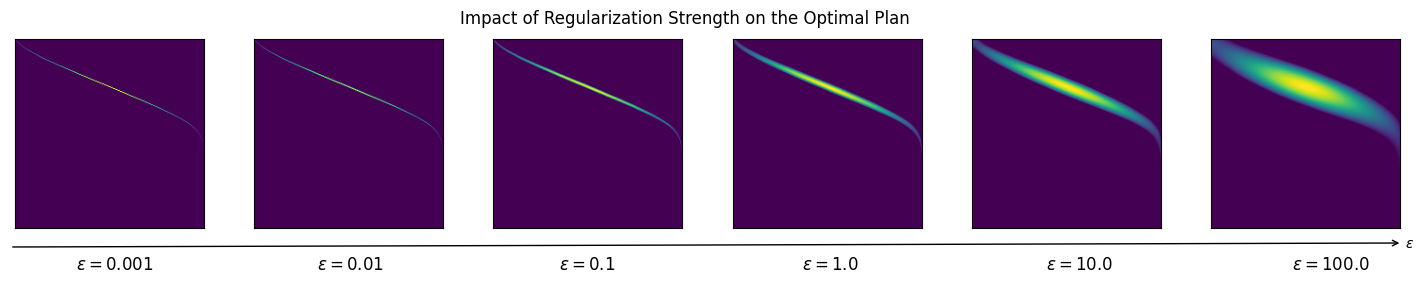

In [63]:
eps_list = [0.001, 0.01, .1, 1.0, 10.0, 100.0]  # List of regularizations to compute EOT (you can put your own)
n_plots = len(eps_list)

# Create a figure and a list of axes for the subplots
fig, axs = plt.subplots(1, n_plots, figsize=(3*n_plots, 3), sharey=True)

# Generate example data and plot each subplot
vals = []  # Store optimal values
vals_sink = []
iters = []
for ax, eps in zip(axs, eps_list):
    s = solve_quadratic_ot_rapdhg(rho1, rho2, C, eps, maxiter=12000, tol=1e-6)
    p_sink = ot.bregman.sinkhorn(rho1, rho2, C, reg=eps)
    vals.append(np.sum(s.avg_primal_solution * C))
    vals_sink.append(np.sum(p_sink * C))
    iters.append(s.num_iterations)
    ax.imshow(s.avg_primal_solution)

    # Hide x-axis labels and ticks for individual plots
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


# Create an axis below all subplots for a common axis
fig.subplots_adjust(bottom=0.25)
common_ax = fig.add_subplot(111, label='common', frame_on=False)
common_ax.tick_params(labelcolor='black', top=False, bottom=False, left=False, right=False)

# Set ticks at positions corresponding to the center of each subplot
x_lims = (0, (3.5)*n_plots)
common_ax.set_xlim(*x_lims)
common_ax.set_xticks([])
common_ax.set_yticks([])
margin_width = (x_lims[1] - 3*n_plots) / (n_plots - 1)
tick_positions = []
curr_tick_p = 1.
for i in range(n_plots):
    common_ax.text(curr_tick_p, -0.19, r'$\epsilon=$'+f'${round(eps_list[i], 3)}$', fontsize=12, ha='left', va='center')
    curr_tick_p += 3.6
    curr_tick_p *= 1.005

# Draw an arrowed axis
common_ax.annotate(r'$\varepsilon$', xy=(0, -0.1), xytext=(1, -0.1), xycoords='axes fraction', textcoords='axes fraction',
                   arrowprops=dict(arrowstyle="<-", color='black'))

fig.suptitle('Impact of Regularization Strength on the Optimal Plan')
fig.show()

Text(0.5, 1.0, 'Cost error for Diminishing Regularization')

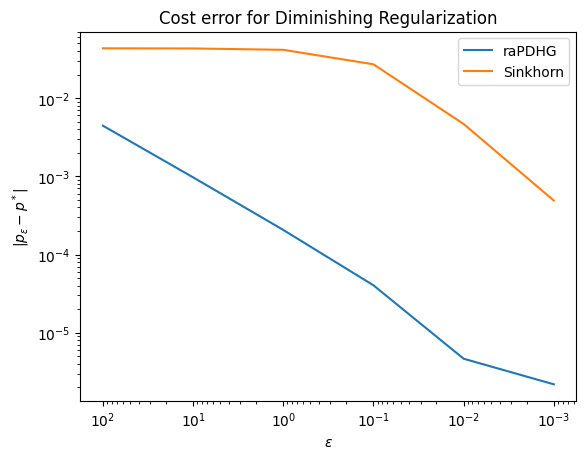

In [67]:
fig, ax = plt.subplots()

vals = np.asarray(vals)
X = eps_list
Y1 = np.abs(vals - np.sum(P_star * C))
Y2= np.abs(vals_sink - np.sum(P_star * C))

ax.loglog(X, Y1, label='raPDHG')
ax.loglog(X, Y2, label='Sinkhorn')
ax.invert_xaxis()
ax.legend()
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel(r'$|p_\varepsilon - p^* |$')
ax.set_title('Cost error for Diminishing Regularization')

Text(0.5, 1.0, 'Number of iterations for the marginals convergence')

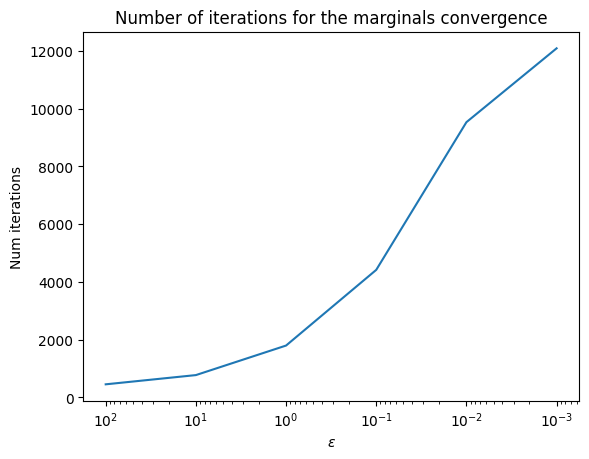

In [53]:
fig, ax = plt.subplots()

vals = np.asarray(vals)
X = eps_list
Y = iters

ax.set_xscale('log')
ax.plot(X, Y)
ax.invert_xaxis()
ax.set_xlabel(r'$\varepsilon$')
ax.set_ylabel(r'Num iterations')
ax.set_title('Number of iterations for the marginals convergence')

## References
---
[1] Antonin Chambolle and Thomas Pock, *A First-Order Primal-Dual Algorithm for Convex Problems with Applications to Imaging*, **Journal of Mathematical Imaging and Vision**.

[2] David Applegate, Mateo Díaz, Oliver Hinder, Haihao Lu, Miles Lubin, Brendan O\'Donoghue, and Warren Schudy, *Practical Large-Scale Linear Programming using Primal-Dual Hybrid Gradient*, **NeurIPS 2021**.

[3] Denys Ruban and Augusto Gerolin, *Primal-dual hybrid algorithms for chi-squared regularized Optimal Transport: statistical-computational trade-offs and applications to Wasserstein Barycenters*, **NeurIPS 2025 OPT Workshop (OpenReview)**, 2025.
